# Company Bankruptcy Prediction

### Load all the necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from random import randrange
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Load the dataset

In [2]:
df = pd.read_csv('data.csv')
df = df.sample(frac=1)
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
3826,0,0.518354,0.549335,0.564912,0.614393,0.614393,0.998981,0.797401,0.809326,0.303519,...,0.805295,0.001012,0.623894,0.614391,0.840558,0.276052,0.026791,0.565158,1,0.080837
3640,0,0.524448,0.572830,0.579849,0.608239,0.608239,0.999068,0.797511,0.809421,0.303529,...,0.816044,0.001037,0.622335,0.608241,0.842867,0.288336,0.027027,0.566077,1,0.017321
5044,0,0.512309,0.574193,0.564698,0.597969,0.597984,0.998968,0.797575,0.809477,0.303851,...,0.822708,0.013667,0.624852,0.597969,0.841424,0.275519,0.026792,0.565165,1,0.125737
1002,0,0.493297,0.554350,0.541410,0.603540,0.603540,0.999001,0.797463,0.809364,0.303587,...,0.807533,0.001144,0.623972,0.603536,0.841142,0.281765,0.026991,0.565958,1,0.023897
2784,0,0.458636,0.532109,0.510520,0.610675,0.610675,0.998861,0.797382,0.809316,0.303737,...,0.796767,0.000314,0.624293,0.610670,0.840081,0.275180,0.026949,0.565813,1,0.204291


### Identify Categorical data types in the dataframe

Check if there are any columns that contain categorical data rather than numeric data, since the latter requires different preprocessing techniques than the former. The results show that 'Bankrupt?', which is the target label, has two categorical values (1 = 'Yes', 0 = 'No'). Among the other features, 'Liability-Assets Flag' has two categorical values, and 'Net Income Flag' only has one value.

In [3]:
for index, val in df.dtypes.iteritems():
    if val == 'int64':
        print(index, val)
        print(df[index].value_counts())
        print()

Bankrupt? int64
0    6599
1     220
Name: Bankrupt?, dtype: int64

 Liability-Assets Flag int64
0    6811
1       8
Name:  Liability-Assets Flag, dtype: int64

 Net Income Flag int64
1    6819
Name:  Net Income Flag, dtype: int64



### Separate the dataset into the features and labels

Separate the 'Bankrupt?' column into a label vector that is to be predicted after processing all the other features. Moreover, remove the 'Net Income Flag' column because the only value in that column is 1, and hence, does not have any predictive quality.

In [4]:
features = df.drop(['Bankrupt?', ' Net Income Flag'], axis=1)
labels = df['Bankrupt?']

### Look for Multicollinearity in the Features

First, take a quick look at the pairwise correlations by plotting the correlation matrix.

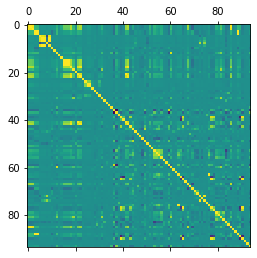

In [5]:
plt.matshow(features.corr())

It is clear that there is some multicollinearity among the features, as indicated by the bright yellow spots in the plot. Hence, the next step is calculate the multicollinearity more rigorously, by means of the variance inflation factor function from Statsmodels.

In [6]:
vif_data = pd.DataFrame()
vif_data['Feature'] = features.columns
vif_data['VIF'] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]
vif_data.sort_values('VIF').tail(10)

,Feature,VIF
5,Operating Profit Rate,1.410654e+08
59,Current Liability to Assets,2.608528e+08
53,Working Capital to Total Assets,3.119776e+08
55,Current Assets/Total Assets,4.713871e+08
37,Net worth/Assets,1.416076e+09
36,Debt ratio %,3.440936e+09
77,Current Liability to Equity,4.442548e+09
65,Current Liabilities/Equity,8.512359e+09
76,Current Liability to Liability,3.510621e+11
63,Current Liabilities/Liability,7.442736e+11


The results shows several variables with high VIF values, which indicates the presence of multicollinearity. Hence, the maximum allowable VIF is fixed (at 10), and the features with values above that threshold are removed, as shown below.

In [7]:
for i in range(len(features.columns)):
    vif_list = [variance_inflation_factor(features.values, index) for index in range(len(features.columns))]
    maxvif = max(vif_list)
    drop_index = vif_list.index(maxvif)
    if maxvif > 10:
        features = features.drop(features.columns[drop_index], axis=1)
    elif maxvif <= 10:
        break

The correlation matrix is checked again to see if the multicollinearity has decreased. The bright yellow spots have vanished from the non-diagonal areas of the plot, which is satisfactory.

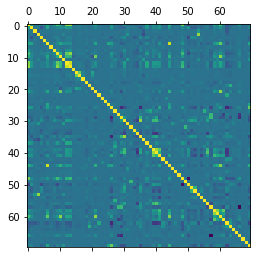

In [8]:
plt.matshow(features.corr())

Now, check the shape of the features data after removing multicollinearity. It has 45 features, which we will use as the input dimension for the neural network.

In [9]:
n_data, n_features = features.shape
print(n_data, n_features)

6819 70


### Scale the features in dataframe

Standard Scaling is performed on the features using the StandardScaler object from Scikit-Learn. The 'Liability-Assets Flag' feature is not scaled because it is a categorical feature.

In [10]:
scaled_features = features
lst = []
for i in features.columns:
    if i != ' Liability-Assets Flag':
        scaler = StandardScaler()
        scaled = scaler.fit_transform(features[i].values.reshape(-1,1))
        scaled_features[i] = scaled
    else:
        pass

scaled_features.head()

,ROA(C) before interest and depreciation before interest,Realized Sales Gross Margin,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),...,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Total assets to GNP price,No-credit Interval,Net Income to Stockholder's Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
3826,0.217111,0.382146,0.017842,-0.009313,-0.616334,-0.750713,-0.051085,-0.151921,-0.829388,-0.143335,...,-0.059965,1.270158,-0.726876,0,-0.049491,-0.001709,0.010749,-0.047870,-0.015101,0.665043
3640,0.317533,0.018288,0.024774,-0.008382,-0.616334,0.065268,-0.110075,-0.151921,-0.262880,-1.009153,...,0.464281,-0.095022,1.167922,0,-0.049491,-0.128545,0.169762,-0.032825,0.054443,-0.605022
5044,0.117493,-0.588001,0.028948,0.020438,1.598375,0.746535,0.517831,-0.151921,-0.321283,2.239557,...,0.295353,-0.216068,-0.523809,0,-0.049491,0.076291,0.070376,-0.047786,-0.014627,1.562850
1002,-0.195822,-0.259506,0.020600,-0.003229,-0.616334,0.007533,-0.170837,-0.151921,1.138058,-0.274596,...,-0.082931,-0.300407,-0.306204,0,-0.049491,0.004634,0.050935,-0.035145,0.045423,-0.473535
2784,-0.767019,0.162297,0.017057,0.010261,-0.616334,-0.750713,-1.679151,-0.151921,-0.829388,-0.684786,...,-1.232167,-1.201349,-0.853799,0,-0.049491,0.030812,-0.022137,-0.037802,0.034424,3.133619


### Split the data into training and test data
Test size is 20% of the size of the total data.

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(scaled_features.values, np.array(tf.one_hot(labels, depth=2)),
                                                    test_size=0.2, random_state=42)

### Create a neural network to train on the data
The model has two hidden layers. The model takes in the features as input, and finally outputs the bankruptcy result.

In [12]:
model = keras.Sequential([
    keras.layers.Dense(22, input_dim=n_features, activation='relu'),
    keras.layers.Dense(11, input_dim=22, activation='relu'),
    keras.layers.Dense(5, input_dim=11, activation='relu'),
    keras.layers.Dense(2, input_dim=5, activation='softmax'),
])

### Compile and train the model

Optimizer is 'adam' and loss is 'binary_crossentropy'.

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=32)

Train on 5455 samples
Epoch 1/10
5455/5455 [==============================] - 2s 282us/sample - loss: 0.3782 - accuracy: 0.9216
Epoch 2/10
5455/5455 [==============================] - 1s 108us/sample - loss: 0.1169 - accuracy: 0.9663
Epoch 3/10
5455/5455 [==============================] - 0s 91us/sample - loss: 0.1019 - accuracy: 0.9663
Epoch 4/10
5455/5455 [==============================] - 0s 88us/sample - loss: 0.0947 - accuracy: 0.9663
Epoch 5/10
5455/5455 [==============================] - 0s 90us/sample - loss: 0.0897 - accuracy: 0.9663
Epoch 6/10
5455/5455 [==============================] - 0s 91us/sample - loss: 0.0863 - accuracy: 0.9663
Epoch 7/10
5455/5455 [==============================] - 0s 88us/sample - loss: 0.0837 - accuracy: 0.9663
Epoch 8/10
5455/5455 [==============================] - 0s 82us/sample - loss: 0.0806 - accuracy: 0.9666
Epoch 9/10
5455/5455 [==============================] - 0s 81us/sample - loss: 0.0787 - accuracy: 0.9665
Epoch 10/10
5455/5455 [========

### Plot the training accuracy and training loss

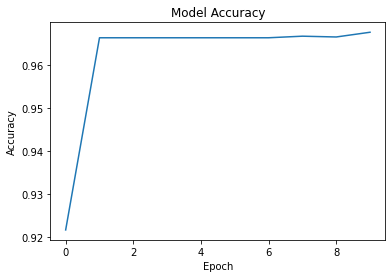

In [15]:
plt.plot(history.history['accuracy'])
# plt.plot(history.history['loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

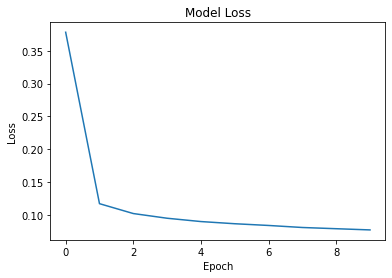

In [17]:
# plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Calculate the test accuracy

In [16]:
_, score = model.evaluate(X_test, Y_test)
print('Accuracy: %.2f' % (score*100))

1364/1364 [==============================] - 0s 176us/sample - loss: 0.0954 - accuracy: 0.9743
Accuracy: 97.43


The model has a high test accuracy score, and moreover, the training loss and accuracy improved as expected. Hence, this is a satisfactory model for predicting bankruptcies in the given context.